In [7]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import time

In [8]:
# Кол-во спинов
MaxN = 20;
# Сколько раз итерируем
Step = int(1e7);

In [9]:
def OneFunction(X):
    return 1;

def GaussianFunction(X):
    Mu = MaxN / 4;
    Sig = 1;
    return np.exp(-np.power(X - Mu, 2.) / (2 * np.power(Sig, 2.))) + 1;

def Cnk(X):
    Spin0 = (int)(MaxN / 2 - X);
    Spin1 = MaxN - Spin0;
    return math.factorial(Spin0 + Spin1) / (math.factorial(Spin0) * math.factorial(Spin1));

In [10]:
def GenerateSample():
    Sample = np.zeros(MaxN + 1); 10 * np.ones(MaxN + 1);
    for i in range(MaxN + 1):
        Sample[i] = Cnk(ConvertIndexToM(i));
    return Sample;

def GenerateField():
    Sample = np.zeros(MaxN + 1);
    return Sample;

def GetRandomIndex():
    return random.randint(0, MaxN - 1);

def GetM(ConfigSpin):
    return 0.5 * ConfigSpin.sum();

#Заменяет значения намагничености на индекс массива
def ConvertMToIndex(M):    
    return (int)(M + MaxN / 2);

#Заменяет значения индекс на намагниченость
def ConvertIndexToM(Index):    
    return (int)(Index - MaxN / 2);

def ConvertSpinToIndex(ConfigSpin):
    Convert2Binary = lambda x: "1" if x == 1 else "0";
    String = np.array2string(ConfigSpin, formatter={'float_kind': Convert2Binary}, separator='');
    String = String.replace('[','');
    String = String.replace(']','');
    return int(String, 2);

In [11]:
def Draw(Sample, Field, path):
    fig = plt.figure(figsize=(20,10));    
    fig.text(0.5, 0.1, 'M', ha='center', va='center');
    fig.text(0.1, 0.5, 'N', ha='center', va='center', rotation='vertical');

    ax_1 = fig.add_subplot(1, 2, 1);
    ax_2 = fig.add_subplot(1, 2, 2);
    ax_1.set_title("Sample");
    ax_2.set_title("Field");

    SampleSum = Sample.sum();
    Sample = Sample * (1 / SampleSum) * 100;

    FieldSum = Field.sum();
    Field = Field * (1 / FieldSum) * 100;
    
    X = np.array(range((int)(-Sample.size / 2), (int)(Sample.size / 2) + 1, 1));    

    ax_1.plot(X, Sample);
    ax_2.plot(X, Field);
    #plt.legend(['Sample', 'Field'], loc=2);
    #plt.xlabel('M');
    #plt.ylabel('N');

    fig.savefig(path + "/plot.png");
    return;

def ConvertIndexToSpin(n):
    S1 = bin(n);
    S1 = S1[2:];    
    S2 = ''.join('0' for i in range(MaxN - len(S1)));
    S1 = S2 + S1;
    for i in range(2,MaxN + int(MaxN / 2),3):
        S1 = S1[:i] + ' ' + S1[i:];
    return S1;

def SpinStatistics(ConfigSpinCounter, Path):
    
    ConfigSpinTouchFile = open(Path + "/ConfigSpinTouch.txt", "a");
    ConfigSpinUnTouchFile = open(Path + "/ConfigSpinUnTouch.txt", "a");
    BriefStatisticsFile = open(Path + "/BriefStatistics.txt", "a");

    #Сколько задействовано было конфигураций
    UniqueSpinCount = 0;
    for i in range(ConfigSpinCounter.size):
        Spin = ConvertIndexToSpin(i);
        Count = ConfigSpinCounter[i];
        Text = "Configuration: " + Spin + '\t' \
            + "Count: " + str(Count) + '\n';

        if int(Count) == 0:
            ConfigSpinUnTouchFile.write(Text);
            continue;

        ConfigSpinTouchFile.write(Text);
        UniqueSpinCount += 1;

    Text = "Unique Spin: " + str(UniqueSpinCount);
    BriefStatisticsFile.write(Text);
    print(Text);
    return;

def SaveResult(Sample, Field, ConfigSpinCounter):
    CurrentTime = time.strftime("%H_%M_%S_%d_%m_%Y", time.localtime());
    
    if os.path.exists(os.getcwd() + "/Result/") != True:
        os.mkdir(os.getcwd() + "/Result/");
        
    Path = os.getcwd() + "/Result/" + CurrentTime;
    os.mkdir(Path);

    Draw(Sample, Field, Path);
    SpinStatistics(ConfigSpinCounter, Path);
    return;

Unique Spin: 93122


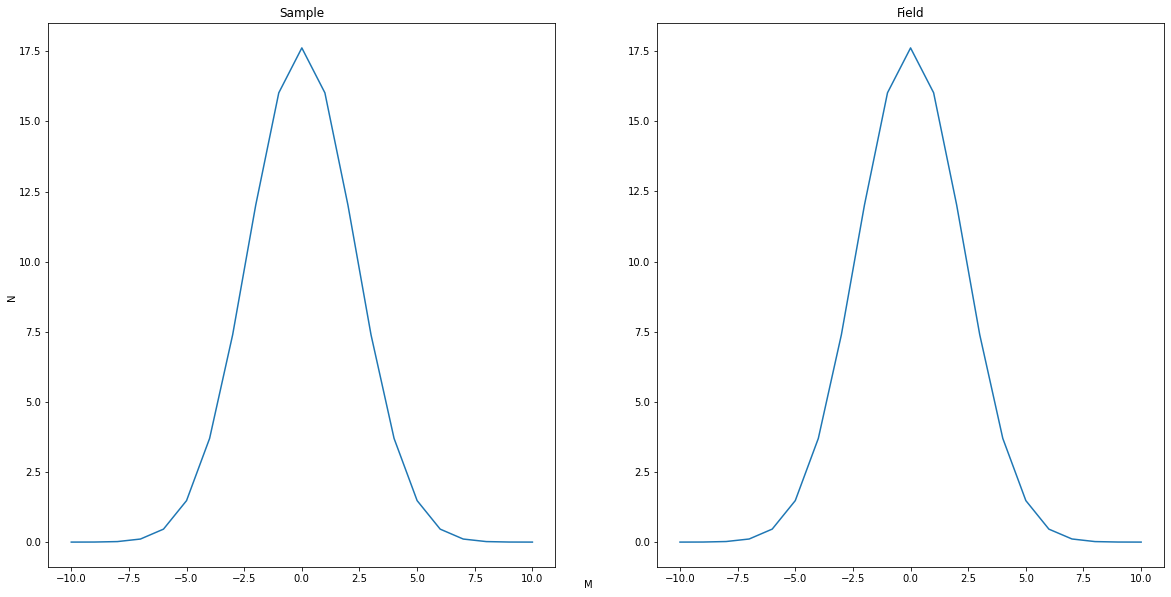

In [12]:
def Main():
    # Семпл как и Филд есть словарь где ключ-значение представлены
    # как M намагниченость - ключ, а значение - сколько раз алгоритм
    # получал такую намагниченость 
    Sample = GenerateSample();
    SampleSum = Sample.sum();

    ConfigSpin = np.ones(MaxN);
    SpinIndex = GetRandomIndex();
    ConfigSpin[SpinIndex] *= -1;
    
    Field =  GenerateField();
    FieldIndex = ConvertMToIndex(GetM(ConfigSpin));
    Field[FieldIndex] += 1;
    FieldSum = Field.sum();

    ConfigSpinCounter = np.zeros(np.power(2, MaxN));
    ConfigSpinCounter[ConvertSpinToIndex(ConfigSpin)] += 1;

    
    Configs = [ i for i in range(MaxN)];
    
    for i in range(Step):
        M = GetM(ConfigSpin);

        NewConfigs = Configs.copy();
        random.shuffle(NewConfigs);

        CurrentH = float("inf");
        NewConfigSpin = ConfigSpin.copy();

        for Config in NewConfigs:            
            TempConfigSpin = ConfigSpin.copy();
            TempConfigSpin[Config] *= -1;           
            FieldIndex = ConvertMToIndex(GetM(TempConfigSpin));

            H1 = Sample[FieldIndex] - SampleSum / (FieldSum + 1) * (Field[FieldIndex] + 1);
            if H1 < 0 :
                H1 = 0;

            H2 = Sample[FieldIndex] - SampleSum / FieldSum * (Field[FieldIndex]);
            if H2 < 0 :
                H2 = 0;

            H = H1 - H2;

            if H < CurrentH:
                CurrentH = H;
                NewConfigSpin = TempConfigSpin.copy();
            
        ConfigSpin = NewConfigSpin;
        FieldIndex = ConvertMToIndex(GetM(ConfigSpin));
        Field[FieldIndex] += 1;
        FieldSum += 1;
        ConfigSpinCounter[ConvertSpinToIndex(ConfigSpin)] += 1;

        

    SaveResult(Sample, Field, ConfigSpinCounter);
    return;

Main();